In [12]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


Epoch [1/120], Train Loss: 5.9601, Val Loss: 5.7051, Test Loss: 5.6309, Train Acc: 22.09%, Val Acc: 67.44%, Test Acc: 77.27%
Epoch [2/120], Train Loss: 5.2687, Val Loss: 4.5687, Test Loss: 4.3050, Train Acc: 77.62%, Val Acc: 88.37%, Test Acc: 81.82%
Epoch [3/120], Train Loss: 3.4540, Val Loss: 1.9452, Test Loss: 1.5464, Train Acc: 83.72%, Val Acc: 88.37%, Test Acc: 81.82%
Epoch [4/120], Train Loss: 1.1836, Val Loss: 0.4276, Test Loss: 0.5026, Train Acc: 83.72%, Val Acc: 88.37%, Test Acc: 81.82%
Epoch [5/120], Train Loss: 0.5727, Val Loss: 0.3194, Test Loss: 0.4109, Train Acc: 83.72%, Val Acc: 88.37%, Test Acc: 81.82%
Epoch [6/120], Train Loss: 0.4675, Val Loss: 0.3396, Test Loss: 0.3869, Train Acc: 83.72%, Val Acc: 88.37%, Test Acc: 81.82%
Epoch [7/120], Train Loss: 0.4478, Val Loss: 0.3188, Test Loss: 0.3955, Train Acc: 83.72%, Val Acc: 88.37%, Test Acc: 81.82%
Epoch [8/120], Train Loss: 0.4452, Val Loss: 0.3246, Test Loss: 0.3901, Train Acc: 83.72%, Val Acc: 88.37%, Test Acc: 81.82%


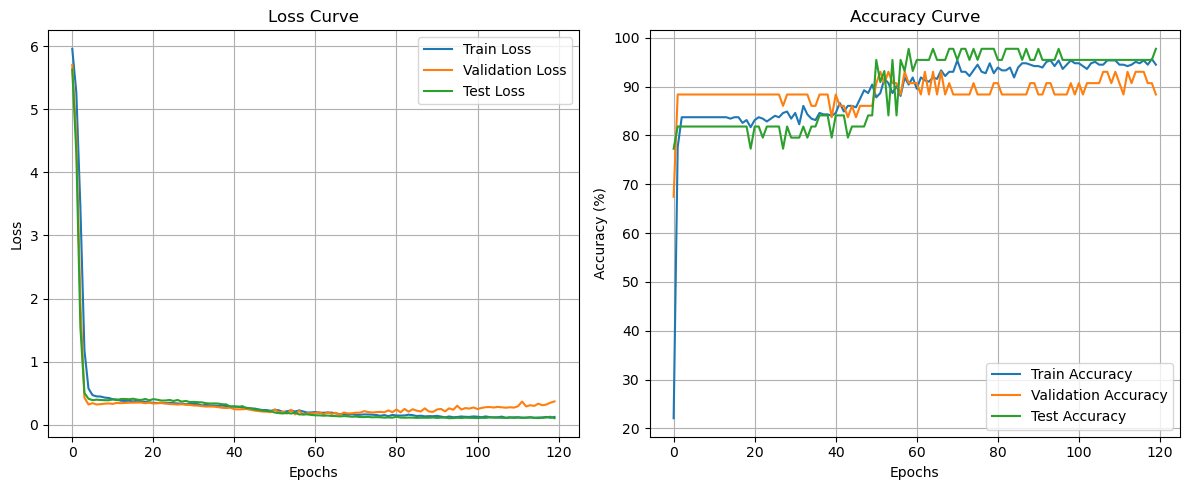

Model saved to lstm_model.pth


In [13]:
def create_dataloaders(data_path, batch_size=32, train_split=0.8, val_split=0.1):
    # Read the dataset
    data = pd.read_csv(data_path)
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values

    class CustomDataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.tensor(features, dtype=torch.float32)
            self.labels = torch.tensor(labels, dtype=torch.long)

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]

    # Shuffle and split data
    indices = np.arange(len(features))
    np.random.shuffle(indices)

    train_end_idx = int(len(indices) * train_split)
    val_end_idx = train_end_idx + int(len(indices) * val_split)

    train_indices = indices[:train_end_idx]
    val_indices = indices[train_end_idx:val_end_idx]
    test_indices = indices[val_end_idx:]

    train_dataset = CustomDataset(features[train_indices], labels[train_indices])
    val_dataset = CustomDataset(features[val_indices], labels[val_indices])
    test_dataset = CustomDataset(features[test_indices], labels[test_indices])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, features.shape[1], len(np.unique(labels))


# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # İlk LSTM Katmanı
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Dropout Katmanı (Aşırı öğrenmeyi önlemek için)
        self.dropout = nn.Dropout(p=0.3)

        # Ek Fully Connected Katman (ReLU ile)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()

        # Son Fully Connected Katman (Softmax ile)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Giriş için sıralı boyut ekleniyor
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        # LSTM Çıkışı
        _, (hidden, _) = self.lstm(x, (h_0, c_0))

        # Dropout
        x = self.dropout(hidden[-1])

        # Ek Fully Connected Katman ve ReLU
        x = self.fc1(x)
        x = self.relu(x)

        # Son Fully Connected Katman
        out = self.fc2(x)
        out = self.softmax(out)
        return out


# Modify training loop to include validation metrics
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_losses = []  # Test kaybı listesi
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []  # Test doğruluğu listesi

    max_val_acc = 0  # Track max validation accuracy

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation Phase
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)
        max_val_acc = max(max_val_acc, val_accuracies[-1])

        # Test Phase
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(100 * correct_test / total_test)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%, "
              f"Test Acc: {test_accuracies[-1]:.2f}%")

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies




# Plot Loss and Accuracy Graphs
# Plot Loss and Accuracy Graphs (Updated)
def plot_metrics(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.plot(test_losses, label="Test Loss")  # Test loss ekleniyor
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")  # Test accuracy ekleniyor
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# Main Execution
data_path = "data/gestures.csv"  
batch_size = 32
hidden_size = 128
epochs = 120

train_loader, val_loader, test_loader, input_size, num_classes = create_dataloaders(data_path, batch_size)

model = LSTMModel(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, epochs
)

plot_metrics(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies)

# Save the trained model
model_path = "lstm_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")